In [2]:
from data import *
from Model import UNet
from DataAugmentation import get_preprocessing, get_validation_augmentation, get_training_augmentation
from DataGenerator import DatasetView, visualize, Dataset
import os
import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm
os.environ["SM_FRAMEWORK"] = "tf.keras"

DATA_DIR = 'C:\\Utils\\GreenAreaDetectionWithDrones\\dataset'
x_train_dir = os.path.join(DATA_DIR, 'images\\redim\\train')
y_train_dir = os.path.join(DATA_DIR, 'masks\\redim\\train')

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

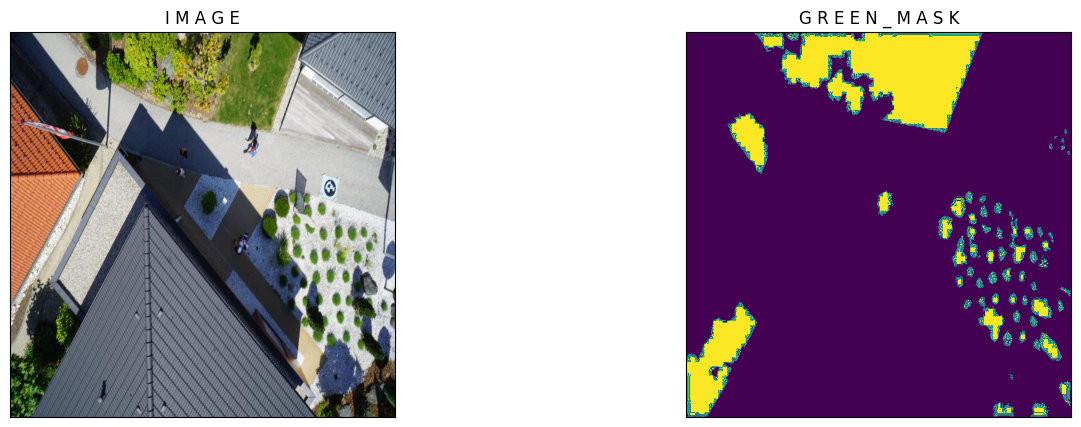

In [4]:

dataset = DatasetView(x_train_dir, y_train_dir, classes=['green'])
image, mask = dataset[5] # get some sample

# con visualize comprobamos que se han cargado correctamente las imagenes
visualize(
    image=image, 
    green_mask=mask
)

In [76]:
train_dataset = Dataset(
    images_dir=x_train_dir,
    masks_dir=y_train_dir,
    classes=['green'], 
    # augmentation=get_training_augmentation(),
    # preprocessing=get_preprocessing(preprocess_input),
)

images_train, masks_train = train_dataset.get_images_and_masks()

X_train = np.asarray(images_train,dtype=np.uint8)
Y_train = np.asarray(masks_train,dtype=bool)

print('X_train:',X_train.shape)
print('Y_train:',Y_train.shape)


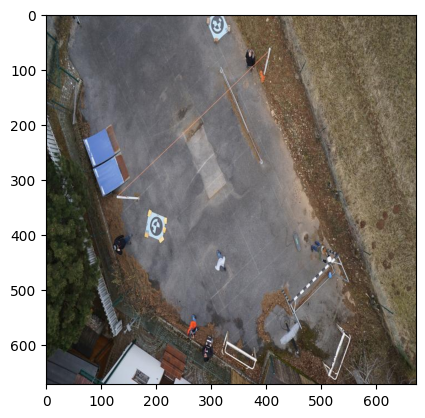

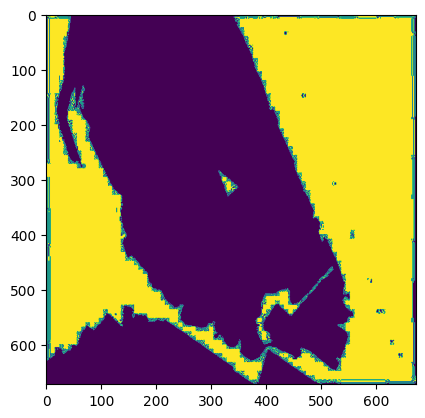

In [9]:
from matplotlib import pyplot as plt

plt.imshow(X_train[1])
plt.show()
plt.imshow(np.squeeze(Y_train[1]))
plt.show()

In [ ]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['green']
LR = 0.0001
EPOCHS = 10
preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

optimizer = Adam(learning_rate=LR)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.weights.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    early_stop,
]

In [13]:
history = model.fit(
    X_train, 
    Y_train,
    validation_split=0.1, 
    batch_size=2, 
    epochs=10,
    callbacks=callbacks, 
)

Epoch 1/10
176/176 [==============================] - 34s 186ms/step - loss: 0.4654 - accuracy: 0.8029 - val_loss: 0.4226 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 2/10
176/176 [==============================] - 31s 176ms/step - loss: 0.3173 - accuracy: 0.8900 - val_loss: 0.1755 - val_accuracy: 0.9455 - lr: 1.0000e-04
Epoch 3/10
176/176 [==============================] - 29s 167ms/step - loss: 0.2780 - accuracy: 0.9089 - val_loss: 0.2353 - val_accuracy: 0.9324 - lr: 1.0000e-04
Epoch 4/10
176/176 [==============================] - 30s 169ms/step - loss: 0.2527 - accuracy: 0.9165 - val_loss: 0.1570 - val_accuracy: 0.9560 - lr: 1.0000e-04
Epoch 5/10
176/176 [==============================] - 30s 168ms/step - loss: 0.2308 - accuracy: 0.9258 - val_loss: 0.1290 - val_accuracy: 0.9563 - lr: 1.0000e-04
Epoch 6/10
176/176 [==============================] - 29s 162ms/step - loss: 0.2317 - accuracy: 0.9233 - val_loss: 0.1374 - val_accuracy: 0.9558 - lr: 1.0000e-04
Epoch 7/10
176/176 [========

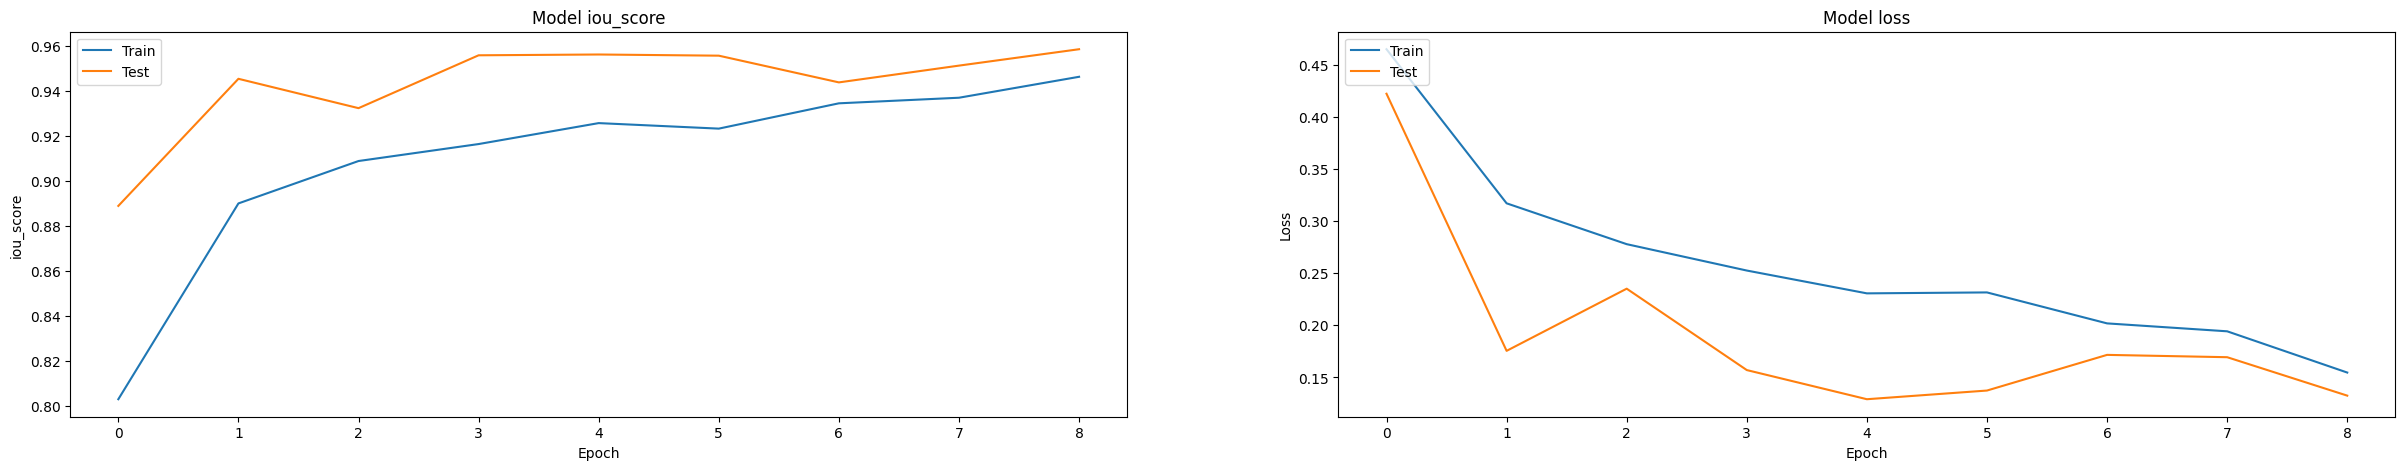

In [17]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()